In [1]:
import datetime
import os
import numpy as np
import scipy.io as sio
import torch
from torch import nn, optim
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
def read_data(base_path='./Data',split_size=[0.6, 0.2, 0.2]):  
    """
    Reads all of the .mat files in the given base_path, and returns a dict with the data found there.
    :param BASE_PATH: the path where the INPUT DATA will be read.
    :param SPLIT_SIZE: gives how much of the data goes to the train/test.
    :return: a dict, containing the EES and difference tensors.
    """
    i = 0
    for file in os.listdir(base_path):
        i = i + 1
    pbar = tqdm(total=i)

    data_dict = {}
    for file in os.listdir(base_path):
        num, data_type = file.split('_')
        data_type = data_type.split('.')[0]
        num = int(num)
        if "EES" in data_type:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['EES_value']
            tensor_in = torch.FloatTensor(tensor_in).squeeze(0)
        else:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['Kulonbseg']
            tensor_in = torch.FloatTensor(tensor_in)
        try:
            data_dict[num][data_type] = tensor_in
        except KeyError:
            data_dict[num] = {data_type: tensor_in}
        pbar.update()
    pbar.close()

    new_data = []
    for key in data_dict.keys():
        new_data.append(data_dict[key])
    np.random.shuffle(new_data)
    if isinstance(split_size, list):
        training_samples = int(split_size[0] * len(new_data))
        valid_samples = int(split_size[1] * len(new_data))
        test_samples = int(split_size[2] * len(new_data))
        while sum([training_samples, valid_samples, test_samples]) != len(new_data):
            training_samples += 1
        #split samples
        new_datadict = {'train': new_data[ : training_samples],
                        'validation': new_data[training_samples : training_samples + valid_samples],
                        'test': new_data[-test_samples : ]}
        
    else:
        new_datadict = {'train': new_data,
                        'validation': new_data,
                        'test': new_data}
    print("Adatbetöltés kész")
    return new_datadict

In [4]:
# Load the data and get the splitted dataset
dataset = read_data()

100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Adatbetöltés kész


In [5]:
class Classificator:

    #-------------------------
    # Label   Class
    #-------------------------
    # 0:      Not damaged
    # 1:      Slightly damaged
    # 2:      Damaged
    # 3:      Very damaged
    #-------------------------
    
    def getClassName(self, c):
        if c==0:
            n = "Not Damaged"
        elif c==1:
            n = "Slightly damaged"
        elif c==2:
            n = "Damaged"
        elif c==3:
            n = "Very damaged"
        return n;
    
    def getClass(self, x):
        x = int(x)
        
        if x==0:
            return 0      
        if x<=100/3:
            return 1
        elif  x>100/3 and x<200/3:
            return 2
        else:
            return 3
    
    # Compare Prediction and Label classes
    def isCorrect(self, prediction, label):
        return self.getClass(prediction) == self.getClass(label)

In [6]:
class CarBadnessGuesser(nn.Module):
    def __init__(self, lr=0.01):
        super(CarBadnessGuesser, self).__init__()

        self.valid_freq = 10

        self.model = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=3, kernel_size=(10, 5, 5), stride=(10, 5, 5)),
            nn.BatchNorm3d(3),
            nn.Conv3d(in_channels=3, out_channels=2, kernel_size=5),
            nn.BatchNorm3d(2),
            nn.Conv3d(in_channels=2, out_channels=1, kernel_size=3),
            nn.BatchNorm3d(1),
            nn.AdaptiveMaxPool3d((1, 1, 10)),
        ) 
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=10, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1),
            nn.ReLU()
        )
        if torch.cuda.is_available():
            self.linear.cuda()
            self.model.cuda()

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(list(self.model.parameters()) + list(self.linear.parameters()), lr=lr)
        
        self.classificator = Classificator()

    def forward(self, x):
        conv_out = self.model(x.unsqueeze(0).unsqueeze(0))
        return self.linear(conv_out.squeeze(-2).squeeze(-2))

    def train(self, epochs=50):
        b_loss = []
        v_loss = []
    
        for epoch in trange(epochs):
            t_correct = 0
            total = 0
            for step, data in enumerate(dataset["train"]):
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)
                #print('training- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                
                loss.backward()     
                self.optimizer.step()
                b_loss.append(loss.item())
                
                #check if its prediction matches label class
                if( self.classificator.isCorrect(prediction.item(), label.item()) ):
                    t_correct += 1;
                total += 1;
                
                self.zero_grad()
            if epoch % self.valid_freq and epoch != 0:
                #calculate the training accuracy
                t_acc = t_correct/total * 100
                #print(f'Batch loss: {loss.item()}', flush=True)
             
                vloss, v_acc = self.validation()
                v_loss.append(vloss)
                print(f'Validation loss:', vloss, flush=True)

                
        print('Training acc:', t_acc, '%')
        print('Validation acc: ', v_acc, '%')  
        plt.plot(v_loss)
        plt.ylabel('Validation loss')
        plt.show()
        plt.plot(b_loss)
        plt.ylabel('Batch loss')
        plt.show()

    def validation(self):
        """
        Runs the validation phase of the training
        :return: The validation loss average
        """
        v_correct = 0
        total = 0
        average_loss = 0
        step = 0
        
        for step, data in enumerate(dataset['validation']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)               
                #print('validation- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                #print('v_correct', v_correct, 'total',total)
                
                average_loss += loss.item()
                
                #check if its correct
                c = self.classificator.isCorrect(prediction.item(), label.item())
                if(c == True):
                    v_correct += 1;
                total += 1;
        
        #calculate the validation accuracy
        v_acc = v_correct/total * 100
        return average_loss / (step + 1), v_acc
        print("Validation is complete")
        

    def test(self):
        """
        Runs the evaluation of the network.
        :return: average loss for the test
        """
        t_correct = 0
        total = 0
        average_loss = 0
        step = 0
        
        for step, data in enumerate(dataset['test']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                prediction = self(input_data)
                
                loss = self.loss_fn(prediction, data['EES'].cuda())
                
                print('---------------------------------')
                print()
                print('Prediction: ', prediction.item())
                print('Excpected:  ', data['EES'].cuda().item())   
                print()
                prediction_label = self.classificator.getClass(prediction.item())
                print('Class:          ', self.classificator.getClassName(prediction_label))
                expected_label = self.classificator.getClass(data['EES'].cuda())
                print('Expected Class: ', self.classificator.getClassName(expected_label))
                print()
                print('loss: ', loss.item())
                print()
                
                #check if its correct
                c = self.classificator.isCorrect(prediction.item(), data['EES'].cuda().item())
                if(c == True):
                    t_correct += 1;
                total += 1;
                
                average_loss += loss.item()

        #calculate the test accuracy
        t_acc = t_correct/total * 100          
        average_loss = average_loss / step   
        print()
        print('---------------------------------')
        print('Test Accuracy: ', t_acc, ' %')
        print('Average Loss:  ', average_loss)
        print('---------------------------------')
        print()
        print("Test is completed")       
        return average_loss


    def save_weights(self, save_dir="./training"):
        """
        Saves weights to the given directory plus the timestamp
        :return: none
        """
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S.%d")
        save_path = os.path.join(save_dir, timestamp)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save model within Training folder with timestamp together with preivous models
        torch.save(self.state_dict(), os.path.join(save_path, 'model.weights'))
        # save last model within Weights folder (overwrite)
        torch.save(self.state_dict(), './weights/model.weights')

    def load_weights(self):
        self.load_state_dict = torch.load('./weights/model.weights')
        print("loading weights is complete")


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\igorr\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:01<01:37,  2.00s/it]

Validation loss: 113.15922403335571


  4%|▍         | 2/50 [00:03<01:29,  1.87s/it]

Validation loss: 122.09900026246905


  6%|▌         | 3/50 [00:05<01:24,  1.79s/it]

Validation loss: 168.73037185668946


  8%|▊         | 4/50 [00:06<01:20,  1.74s/it]

Validation loss: 118.98170700073243


 10%|█         | 5/50 [00:08<01:16,  1.70s/it]

Validation loss: 85.27647659778594


 12%|█▏        | 6/50 [00:10<01:14,  1.69s/it]

Validation loss: 66.9152284860611


 14%|█▍        | 7/50 [00:11<01:11,  1.65s/it]

Validation loss: 42.98451057747006


 16%|█▌        | 8/50 [00:13<01:09,  1.65s/it]

Validation loss: 27.748868384957312


 18%|█▊        | 9/50 [00:14<01:07,  1.63s/it]

Validation loss: 15.651922988891602


 22%|██▏       | 11/50 [00:17<01:00,  1.55s/it]

Validation loss: 4.652549976110459


 24%|██▍       | 12/50 [00:19<01:00,  1.60s/it]

Validation loss: 5.126523279584944


 26%|██▌       | 13/50 [00:21<00:59,  1.60s/it]

Validation loss: 3.1966773867490703


 28%|██▊       | 14/50 [00:22<00:57,  1.60s/it]

Validation loss: 12.531212290748954


 30%|███       | 15/50 [00:24<00:56,  1.62s/it]

Validation loss: 2.6754921792075037


 32%|███▏      | 16/50 [00:26<00:54,  1.61s/it]

Validation loss: 8.934701378643513


 34%|███▍      | 17/50 [00:27<00:53,  1.62s/it]

Validation loss: 7.063330078870058


 36%|███▌      | 18/50 [00:29<00:51,  1.61s/it]

Validation loss: 2.109711303934455


 38%|███▊      | 19/50 [00:30<00:49,  1.60s/it]

Validation loss: 11.09040451347828


 42%|████▏     | 21/50 [00:33<00:44,  1.52s/it]

Validation loss: 2.877452010475099


 44%|████▍     | 22/50 [00:35<00:43,  1.56s/it]

Validation loss: 9.00829260777682


 46%|████▌     | 23/50 [00:37<00:42,  1.57s/it]

Validation loss: 4.380811662971974


 48%|████▊     | 24/50 [00:38<00:41,  1.59s/it]

Validation loss: 10.486065045930445


 50%|█████     | 25/50 [00:40<00:39,  1.59s/it]

Validation loss: 6.524911260604858


 52%|█████▏    | 26/50 [00:41<00:38,  1.61s/it]

Validation loss: 2.0583175828793174


 54%|█████▍    | 27/50 [00:43<00:36,  1.61s/it]

Validation loss: 4.5359663929790255


 56%|█████▌    | 28/50 [00:45<00:35,  1.60s/it]

Validation loss: 11.70703355781734


 58%|█████▊    | 29/50 [00:46<00:33,  1.61s/it]

Validation loss: 4.793762173503637


 62%|██████▏   | 31/50 [00:49<00:29,  1.54s/it]

Validation loss: 3.796131482720375


 64%|██████▍   | 32/50 [00:51<00:27,  1.55s/it]

Validation loss: 4.971681919693947


 66%|██████▌   | 33/50 [00:52<00:26,  1.57s/it]

Validation loss: 12.935127495205961


 68%|██████▊   | 34/50 [00:54<00:25,  1.58s/it]

Validation loss: 9.57746287882328


 70%|███████   | 35/50 [00:56<00:23,  1.59s/it]

Validation loss: 1.9559749638661743


 72%|███████▏  | 36/50 [00:57<00:22,  1.58s/it]

Validation loss: 3.1590401380788533


 74%|███████▍  | 37/50 [00:59<00:20,  1.59s/it]

Validation loss: 2.485017842994421


 76%|███████▌  | 38/50 [01:00<00:19,  1.60s/it]

Validation loss: 7.777603026945144


 78%|███████▊  | 39/50 [01:02<00:17,  1.60s/it]

Validation loss: 2.959725693613291


 82%|████████▏ | 41/50 [01:05<00:13,  1.53s/it]

Validation loss: 7.158006471162662


 84%|████████▍ | 42/50 [01:07<00:12,  1.57s/it]

Validation loss: 10.674431660688423


 86%|████████▌ | 43/50 [01:08<00:11,  1.58s/it]

Validation loss: 8.019755917973816


 88%|████████▊ | 44/50 [01:10<00:09,  1.59s/it]

Validation loss: 10.33954727742821


 90%|█████████ | 45/50 [01:11<00:07,  1.59s/it]

Validation loss: 5.962130428710952


 92%|█████████▏| 46/50 [01:13<00:06,  1.60s/it]

Validation loss: 6.934577837772667


 94%|█████████▍| 47/50 [01:15<00:04,  1.61s/it]

Validation loss: 7.509366810880602


 96%|█████████▌| 48/50 [01:16<00:03,  1.61s/it]

Validation loss: 5.151559401187114


 98%|█████████▊| 49/50 [01:18<00:01,  1.63s/it]

Validation loss: 3.9090518768178297


100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


Training acc: 100.0 %
Validation acc:  90.0 %


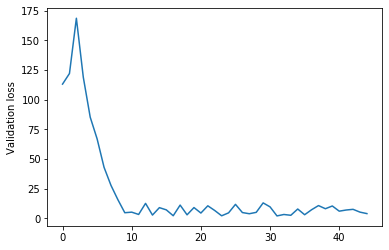

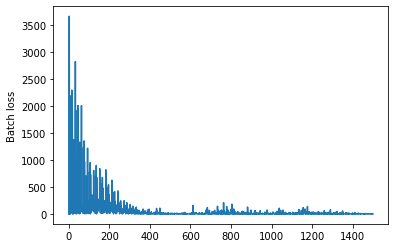

loading weights is complete
---------------------------------

Prediction:  5.4377264976501465
Excpected:   5.396796226501465

Class:           Slightly damaged
Expected Class:  Slightly damaged

loss:  0.001675287145189941

---------------------------------

Prediction:  34.62641906738281
Excpected:   41.422237396240234

Class:           Damaged
Expected Class:  Damaged

loss:  46.18314743041992

---------------------------------

Prediction:  0.24766641855239868
Excpected:   0.5625600218772888

Class:           Not Damaged
Expected Class:  Not Damaged

loss:  0.09915798157453537

---------------------------------

Prediction:  0.044789738953113556
Excpected:   0.0

Class:           Not Damaged
Expected Class:  Not Damaged

loss:  0.0020061207469552755

---------------------------------

Prediction:  25.922250747680664
Excpected:   40.691123962402344

Class:           Slightly damaged
Expected Class:  Damaged

loss:  218.11961364746094

---------------------------------

Prediction:  

In [7]:
if __name__ == "__main__":
    
    # set mode
    TRAIN = True
    TEST = True
    
    # instanciate the NN
    net = CarBadnessGuesser()
    torch.backends.cudnn.enabled = False

    # Train, Validate and Save the model
    if(TRAIN):
        net.train()
        net.save_weights()
    
    # Load the model and Test
    if(TEST):
        net.load_weights()
        net.test()
    